## BTC Forecasting in PyTorch using LSTM

In [70]:
import yfinance as yf 

symbol = 'BTC-USD'

btc_data = yf.download(symbol)
btc_data.to_csv('BTC-USD.csv')

[*********************100%%**********************]  1 of 1 completed


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
 
import torch
import torch.nn as nn

data = pd.read_csv('BTC-USD.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3717,2024-11-20,92341.890625,94902.023438,91619.500000,94339.492188,94339.492188,71730956426
3718,2024-11-21,94334.640625,99014.218750,94132.601562,98504.726562,98504.726562,106024505582
3719,2024-11-22,98496.429688,99655.500000,97222.664062,98997.664062,98997.664062,78473580551
3720,2024-11-23,99006.742188,99014.679688,97232.890625,97777.281250,97777.281250,44414644677


In [72]:
data = data[['Date','Close']]
data

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3717,2024-11-20,94339.492188
3718,2024-11-21,98504.726562
3719,2024-11-22,98997.664062
3720,2024-11-23,97777.281250


In [73]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [74]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3722 entries, 0 to 3721
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
3722 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 29.2 KB


C:\Users\ivoto\AppData\Local\Temp\ipykernel_17220\4140636855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


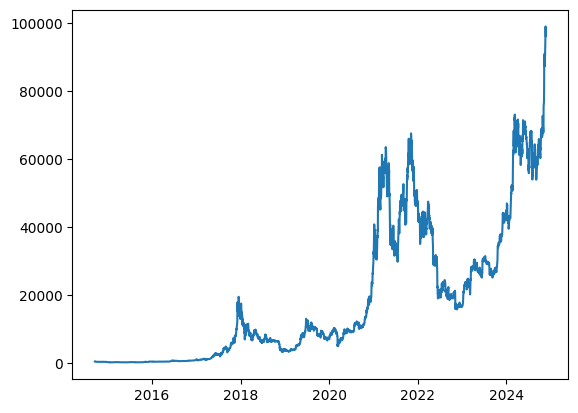

In [75]:
plt.plot(data['Date'],data['Close'])

In [76]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,377.181000,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...
2024-11-20,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688,90584.164062
2024-11-21,98504.726562,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688
2024-11-22,98997.664062,98504.726562,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812


In [77]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[  423.20498657,   435.79098511,   402.15200806, ...,
          394.79598999,   424.44000244,   457.33401489],
       [  411.57400513,   423.20498657,   435.79098511, ...,
          408.9039917 ,   394.79598999,   424.44000244],
       [  404.42498779,   411.57400513,   423.20498657, ...,
          398.8210144 ,   408.9039917 ,   394.79598999],
       ...,
       [98997.6640625 , 98504.7265625 , 94339.4921875 , ...,
        89845.8515625 , 90558.4765625 , 91066.0078125 ],
       [97777.28125   , 98997.6640625 , 98504.7265625 , ...,
        90542.640625  , 89845.8515625 , 90558.4765625 ],
       [96183.3828125 , 97777.28125   , 98997.6640625 , ...,
        92343.7890625 , 90542.640625  , 89845.8515625 ]])

#### Normalization

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np.shape

(3715, 8)

#### Train and Test

In [79]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3715, 7), (3715,))

In [80]:
X = dc(np.flip(X, axis=1 ))
X

array([[-0.99385549, -0.99457932, -0.99529775, ..., -0.99551051,
        -0.99546549, -0.99478468],
       [-0.99457932, -0.99523164, -0.99499161, ..., -0.99544276,
        -0.99478468, -0.9950394 ],
       [-0.99523164, -0.99492119, -0.99521041, ..., -0.99475853,
        -0.9950394 , -0.9952748 ],
       ...,
       [ 1.        ,  0.98883171,  0.94579463, ...,  0.87468425,
         0.90572369,  0.99002348],
       [ 0.98883171,  0.97315031,  0.96091499, ...,  0.91527759,
         0.99002348,  1.        ],
       [ 0.97315031,  0.98848324,  1.        , ...,  1.        ,
         1.        ,  0.97530078]])

In [81]:
split_index = int(len(X) * 0.99)
split_index

3677

In [82]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3677, 7), (38, 7), (3677,), (38,))

#### Add a dimension

In [83]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3677, 7, 1), (38, 7, 1), (3677, 1), (38, 1))

#### Convert the sets to Pytorch Tensors

In [84]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3677, 7, 1]),
 torch.Size([38, 7, 1]),
 torch.Size([3677, 1]),
 torch.Size([38, 1]))

In [85]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [86]:
x_sample, y_sample = train_dataset[10]
print(x_sample.shape)  # Imprimirá torch.Size([7, 1])
print(y_sample.shape)  # Imprimirá torch.Size([1])

torch.Size([7, 1])
torch.Size([1])


In [87]:
from torch.utils.data import DataLoader

batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [88]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


#### Create the model

In [89]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#### Function and training loop

In [90]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()


In [91]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


In [92]:
learning_rate = 0.01
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1


Batch 100, Loss: 0.033
Batch 200, Loss: 0.001

Val Loss: 0.067
***************************************************

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.059
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.042
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.024
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.020
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.013
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.014
***************************************************

Epoch: 8
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.015
***************************************************

Epoch: 9


### Visualizacion

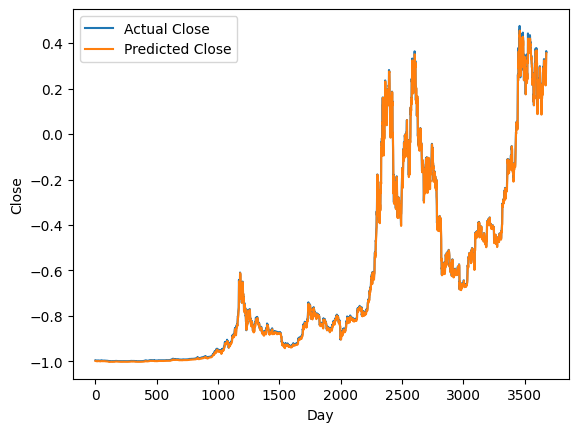

In [93]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy() #Es porque numpy no usa GPU 

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

##### Anti-transformada de los Precios 

In [94]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  285.09086103,   282.9144673 ,   276.63561554, ...,
       65559.07654563, 66594.40972286, 67160.40756669])

In [95]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  423.20498424,   411.57497224,   404.42438497, ...,
       67041.10938338, 67612.71902459, 67399.83591062])

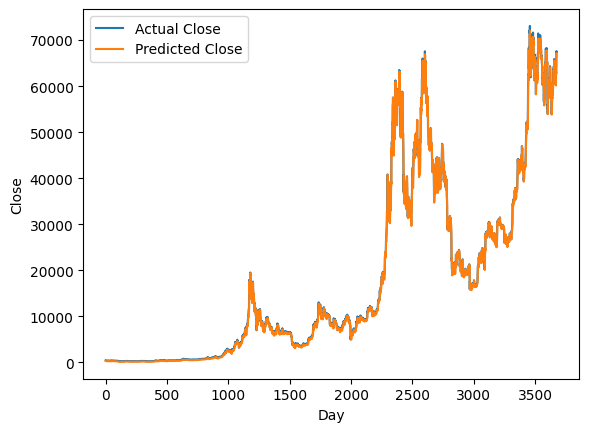

In [96]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [97]:
X_test.shape


torch.Size([38, 7, 1])

In [98]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([67022.93251986, 67901.03229359, 67915.62797337, 68473.19413213,
       67124.48970741, 67034.75690532, 66203.81036584, 67631.55410733,
       66407.9790697 , 66665.04975014, 67454.57412737, 69181.88860073,
       71597.90947193, 71480.61392426, 69849.50547821, 69133.53378509,
       68875.01413887, 68373.73087685, 67532.85067557, 68760.12764408,
       73841.94222702, 74371.09746511, 75105.44039521, 75392.08529202,
       78153.34876797, 83820.58970554, 83618.75937329, 85826.79475269,
       83891.16494166, 86484.26297954, 86043.3886327 , 85841.26085016,
       86258.12123959, 87312.09954367, 88505.09610205, 90932.84417197,
       91176.21741361, 90787.0346268 ])

In [99]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([68418.78870631, 68362.73405113, 69001.70293122, 67367.85116885,
       67361.40592163, 66432.1947632 , 68161.05538908, 66642.41407726,
       67014.69520825, 67929.29743417, 69907.7571425 , 72720.49277207,
       72339.5384617 , 70215.18821926, 69482.46948558, 69289.27404701,
       68741.11733073, 67811.50711769, 69359.56214053, 75639.07800308,
       75904.86014857, 76545.47678549, 76778.86629944, 80474.1884901 ,
       88701.48397743, 87955.81143068, 90584.16469105, 87250.43014606,
       91066.00766206, 90558.47794387, 89845.85183029, 90542.63945197,
       92343.78933447, 94339.4923247 , 98504.72707903, 98997.6640625 ,
       97777.2814617 , 96183.38375294])

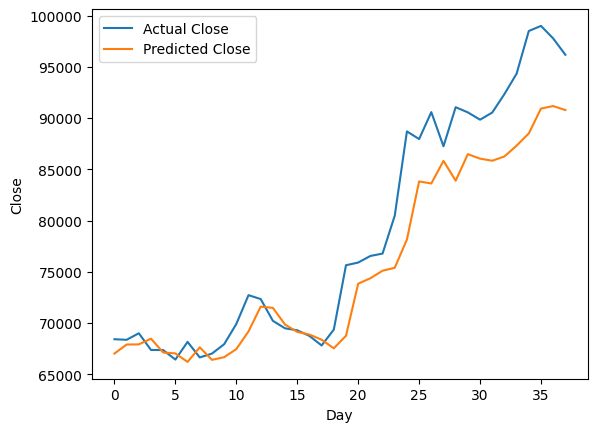

In [100]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()